# LiDAR Uncertainty at NEON Sites SOAP and SJER

In [1]:
import os
import pathlib

import earthpy as et
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rasterstats as rs
import rioxarray as rxr
import xarray as xr
import clean

# Download data
et.data.get_data('spatial-vector-lidar')

# Change working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'spatial-vector-lidar')
os.chdir(working_dir) 

### Create paths for data

In [2]:
# Paths to SJER data
sjer_base_dir = os.path.join('california', 'neon-sjer-site')

sjer_insitu_path = os.path.join(sjer_base_dir,
                                '2013',
                                'insitu',
                                'veg_structure',
                                'D17_2013_SJER_vegStr.csv')
sjer_plots_path = os.path.join(sjer_base_dir,
                               'vector_data',
                               'SJER_plot_centroids.shp')
sjer_chm_path = os.path.join(sjer_base_dir,
                             '2013',
                             'lidar',
                             'SJER_lidarCHM.tif')

# Paths to SOAP data
soap_base_dir = os.path.join('california', 'neon-soap-site')

soap_insitu_path = os.path.join(soap_base_dir,
                                '2013',
                                'insitu',
                                'veg_structure',
                                'D17_2013_SOAP_vegStr.csv')
soap_plots_path = os.path.join(soap_base_dir,
                               'vector_data',
                               'SOAP_centroids.shp')
soap_chm_path = os.path.join(soap_base_dir,
                             '2013',
                             'lidar',
                             'SOAP_lidarCHM.tif')

### Function to calculate LiDAR CHM statistics, insitu height statistics, and merge LiDAR and insitu data

In [5]:
def calc_height_stats(plots_path, chm_path, insitu_path, id_col='Plot_ID'):
    """
    Calculate stem height statistics from lidar and in-situ measurements 
    for each plot.


    Parameters
    ----------
        plots_path: str
            The file path to the shapefile containing plot perimeters. 
            The shapefile must have a column for plot ID.
        chm_path: str
            The file path to the raster file containing lidar-derived canopy 
            height models (CHMs).
        insitu_path: str
            The file path to the CSV file containing the in-situ stem height 
            measurements.
        id_col: str, optional
            The name of the column in the shapefile and CSV file that contains 
            the plot ID. Defaults to 'Plot_ID'.

    Returns
    -------
        pd.DataFrame: A Pandas DataFrame with columns for plot ID, 
        lidar-derived mean and maximum stem height, and in-situ mean and 
        maximum stem height.

    """

    def calc_lidar_chm_stats(plots_path, chm_path):
        """
        Calculate lidar statistics max and mean for a canopy height model (CHM) 
        within polygons.

        This function reads a shapefile of polygons from a file path and calculates
        the perimeter of each polygon by setting a buffer of 20. It then calculates
        zonal statistics for a CHM raster file (in GeoTIFF format) within each polygon.
        The statistics calculated are the maximum and mean height of vegetation within
        each polygon. The output is a GeoDataFrame containing the original polygons and
        the lidar statistics as additional columns.

        Parameters
        ----------
            plots_path: str: 
                The file path to the shapefile containing the polygons.
            chm_path: str
                The file path to the CHM raster file in GeoTIFF format.

        Returns
        -------
            gpd.GeoDataFrame: A GeoDataFrame containing the original polygons and the lidar
            statistics as additional columns.

        Raises
        ------
            FileNotFoundError: If either the plots_path or chm_path file does not exist.

        """
        # Calculate plot perimeters
        plots_gdf = gpd.read_file(plots_path)
        # Set buffer to 20
        plots_gdf.geometry = plots_gdf.geometry.buffer(20)

        # Calculate zonal stats for CHM
        chm_stats = rs.zonal_stats(plots_gdf, chm_path,
                                   stats=['mean', 'max'],
                                   nodata=0, geojson_out=True,
                                   copy_properties=True)
        # Turn into geoDataFrame
        chm_stats_gdf = gpd.GeoDataFrame.from_features(chm_stats)
        # Rename columns
        chm_stats_gdf.rename(
            columns={'max': 'lidar_max', 'mean': 'lidar_mean'}, inplace=True)
        # For SOAP path add SOAP to ids
        if chm_path is soap_chm_path:
            # Change ID
            chm_stats_gdf['ID'] = "SOAP" + chm_stats_gdf["ID"]

        return chm_stats_gdf

    def calc_insitu_height_stats(insitu_path):
        """
        Calculate in-situ stem height statistics for each plot.

        This function reads a CSV file of in-situ stem height measurements from a 
        file path. It groups the measurements by plot ID and calculates the mean 
        and maximum stem height for each plot. The output is a Pandas DataFrame 
        with columns for the plot ID, the mean stem height, and the maximum stem 
        height.

        Parameters
        ----------
            insitu_path: str
                The file path to the CSV file containing the in-situ stem height 
                measurements. The file must have columns for plot ID and stem 
                height.

        Returns
        -------
            pd.DataFrame: A Pandas DataFrame with columns for plot ID, 
            mean stem height, and maximum stem height.

        Raises
        -------
            FileNotFoundError: If the insitu_path file does not exist.
            KeyError: If the CSV file does not have columns for plot ID and stem 
            height.

            """
        insitu_height_stats = (
            pd.read_csv(insitu_path)
            .groupby('plotid')
            .stemheight
            .agg(['mean', 'max'])
            .rename(columns={"mean": "insitu_mean",
                             "max": "insitu_max"})
        )

        return insitu_height_stats

    chm_stats_gdf = calc_lidar_chm_stats(
        plots_path=plots_path, chm_path=chm_path)

    insitu_height_df = calc_insitu_height_stats(
        insitu_path=insitu_path)

    stat_df = chm_stats_gdf.merge(insitu_height_df, right_index=True,
                                  left_on=id_col)
    return stat_df

### Function to create plots

In [6]:
def create_subplot(stat_df, ax, x, y, xlabel, ylabel, title, xlim_min,
                   xlim_max, ylim_min, ylim_max):
    """
    Plot a scatter plot and regression line on a subplot.

    Parameters
    ----------
    stat_df : pandas.DataFrame
        The data to be plotted.
    ax : matplotlib.axes.Axes
        The subplot to plot on.
    x : str
        The name of the column in `stat_df` to use for the x-axis.
    y : str
        The name of the column in `stat_df` to use for the y-axis.
    xlabel : str
        The label for the x-axis.
    ylabel : str
        The label for the y-axis.
    title : str
        The title for the subplot.
    xlim_min : float
        The minimum value for the x-axis limit.
    xlim_max : float
        The maximum value for the x-axis limit.
    ylim_min : float
        The minimum value for the y-axis limit.
    ylim_max : float
        The maximum value for the y-axis limit.

    Returns
    -------
    matplotlib.axes.Axes
        The subplot with the scatter plot and regression line.
    """
    # plot 1
    stat_df.plot(x=x,
                 y=y,
                 kind='scatter',
                 fontsize=14,
                 s=45, ax=ax)

    # regression line 1
    sns.regplot(x=x, y=y,
                data=stat_df,
                ax=ax)

    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title=title)

    # Add 1:1 line
    ax.plot((0, 1), (0, 1),
            transform=ax.transAxes, ls='--', c='k')

    # Adjust x and y axis limits
    ax.set(xlim=[xlim_min, xlim_max], ylim=[ylim_min, ylim_max])

    return ax

## San Joaquin Experimental Range (SJER) NEON Field Site

![ San Joaquin Experimental Range NEON](img/sjersite.jpg)
Image credit: National Ecological Observation Network https://www.neonscience.org/field-sites/sjer

###  Lidar Data Compared to Ground Measurements for SJER Field  Site

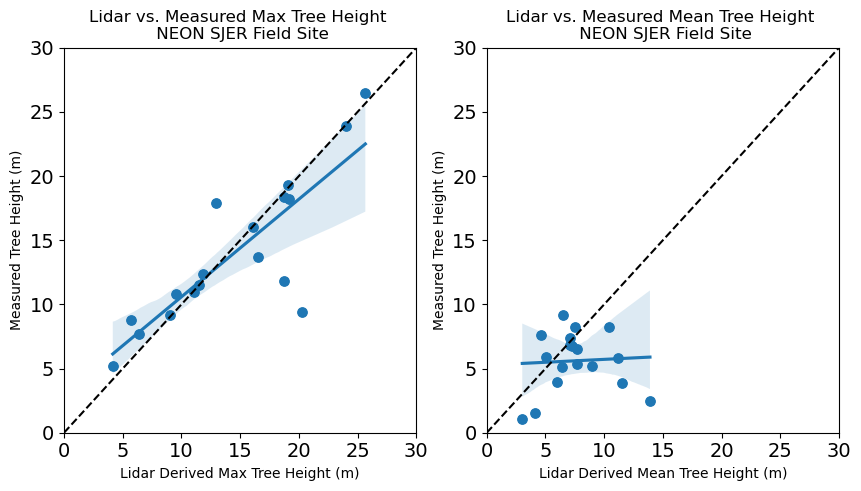

In [7]:
# Create stats to enter into plot using calc_height_stats function
sjer_height_stats = calc_height_stats(
    plots_path=sjer_plots_path,
    chm_path=sjer_chm_path,
    insitu_path=sjer_insitu_path)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1
create_subplot(sjer_height_stats,
               ax=ax1,
               x="lidar_max",
               y='insitu_max',
               xlabel="Lidar Derived Max Tree Height (m)",
               ylabel="Measured Tree Height (m)",
               title="Lidar vs. Measured Max Tree Height \n NEON SJER Field Site",
               xlim_min=0,
               xlim_max=30,
               ylim_min=0,
               ylim_max=30)

# Plot 2
create_subplot(sjer_height_stats,
               ax=ax2,
               x="lidar_mean",
               y='insitu_mean',
               xlabel="Lidar Derived Mean Tree Height (m)",
               ylabel="Measured Tree Height (m)",
               title="Lidar vs. Measured Mean Tree Height \n NEON SJER Field Site",
               xlim_min=0,
               xlim_max=30,
               ylim_min=0,
               ylim_max=30)

plt.show()

## Soaproot Saddle (SOAP) NEON Field Site

![Soaproot Saddle NEON](img/Soaproot_pano.jpg)
Image credit: National Ecological Observation Network https://www.neonscience.org/field-sites/soap

###  Lidar Data Compared to Ground Measurements for SOAP Field  Site

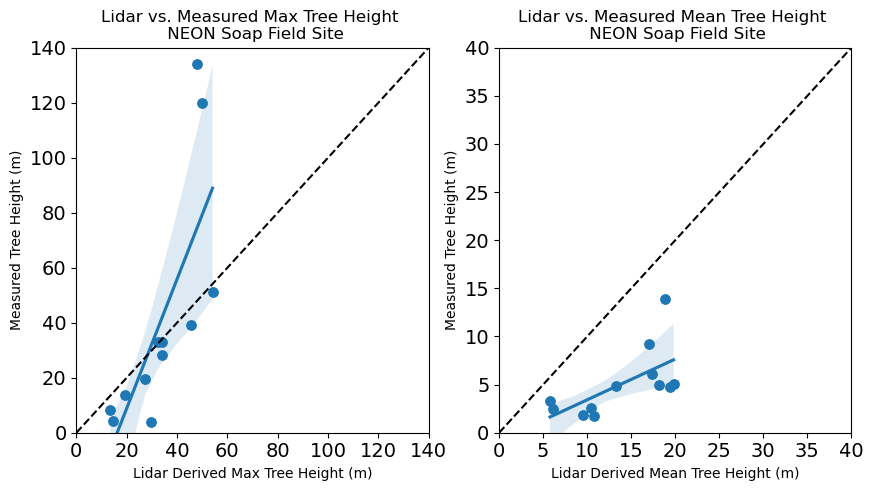

In [8]:
# Create stats to enter into plot using calc_height_stats function
soap_height_stats = calc_height_stats(
    plots_path=soap_plots_path,
    chm_path=soap_chm_path,
    insitu_path=soap_insitu_path,
    id_col='ID')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1
create_subplot(soap_height_stats,
               ax=ax1,
               x="lidar_max",
               y='insitu_max',
               xlabel="Lidar Derived Max Tree Height (m)",
               ylabel="Measured Tree Height (m)",
               title="Lidar vs. Measured Max Tree Height \n NEON Soap "
               "Field Site",
               xlim_min=0,
               xlim_max=140,
               ylim_min=0,
               ylim_max=140)

# Plot 2
create_subplot(soap_height_stats,
               ax=ax2,
               x="lidar_mean",
               y='insitu_mean',
               xlabel="Lidar Derived Mean Tree Height (m)",
               ylabel="Measured Tree Height (m)",
               title="Lidar vs. Measured Mean Tree Height \n NEON Soap Field Site",
               xlim_min=0,
               xlim_max=40,
               ylim_min=0,
               ylim_max=40)

plt.show()